# Storing JPEG compressed images in netCDF

Before we show how we store JPEG compressed images in netCDF, we need to explain why we want to do that in the first place. Lets start with an image.

We load an image using scipys imread function. Scipys uses the python image library PIL or Pillow for reading and writing images and translates images into numpy arrays. The image size is about 8kB.

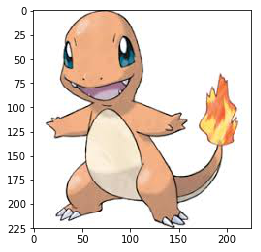

In [1]:
% matplotlib inline
import numpy as np
from scipy.misc import imread, imsave
import matplotlib.pyplot as plt

arr = imread('charmander.jpg')

plt.imshow(arr)

In order to interact with the netCDF library we use the open source package xarray. NetCDF allows us to store n-dim arrays with labeled coordinates. But for this example we wont use any labels. We simply store the image as numpy array. In order to reduce memory we use xarrays zlib compression.

In [2]:
import xarray as xr
ds = xr.Dataset({'image': (['x', 'y', 'rgb'], arr)})

enc_dict = dict(zlib=True, complevel=5)
encoding = {'image': enc_dict}

ds.to_netcdf('zlib_charmander.nc', encoding=encoding)
ds

<xarray.Dataset>
Dimensions:  (rgb: 3, x: 225, y: 225)
Dimensions without coordinates: rgb, x, y
Data variables:
    image    (x, y, rgb) uint8 255 255 255 255 255 255 255 255 255 255 255 ...

Even with zlib compression level 5 the resulting netCDF file is about 80kB large. Thats more then 10 times the size of the original file.

When you store a lot of images this way the amount of memory needed can defeat the benefits of using the netCDF format. For example you might have additional data or meta data that belongs to your images and you want to store everything in one place.

Since xarray does not yet support JPEG compression we had to come up with an alternative. Instead of storing the image as a n-dim array we apply JPEG compression as if we were to store a jpeg file. But instead of storing the resulting byte string on a disk we put it in an numpy array and create a xarray dataset with it. This dataset can be stored in a netCDF file with as much meta data and labels as you need.

In [3]:
from scipy.misc.pilutil import toimage
from io import StringIO, BytesIO

# Compress image using JPEG format and store as byte string
img = toimage(arr)
compressed = BytesIO()
img.save(compressed, format='JPEG', quality=75)

# store jpeg compressed image in netCDF
ds = xr.Dataset({'jpg': (['cc'], np.array([compressed.getvalue()]))})
ds.to_netcdf('charmander.nc')

This new netCDF file is only about 20kB large. It is larger than our raw jpeg file which is because of the netCDF overhead.

We can no longer use the dimensions of the image since it is stored as a string and when we read the netCDF file we have to translate that string into bytes again before we can restore our image.

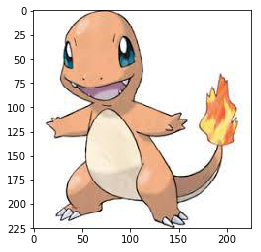

In [4]:
ds = xr.open_dataset('charmander.nc')
 
img = imread(BytesIO(ds['jpg'].item(0)))

plt.imshow(img)